<a href="https://colab.research.google.com/github/tettolizer/OrigamiAirBag/blob/main/Fold_Origamiv2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
from math import *
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import collections  as mc
from matplotlib.patches import Ellipse, Wedge, Polygon
from matplotlib.path import Path
import matplotlib
import itertools

from scipy.spatial import distance
from scipy import signal
from google.colab import files


The system for the curved tesselation starts with a kernel-curve. It has specific properties detailed in the book but generally can be represented with most bell-shaped curves.

The rest of the system is easier if you start only with the first half of the bell.

I'm using a Gaussian curve (normalized to the shape I want). I believe that generating different kernels by changing `curve_h_of_c` will lead to compatible curves for patterns such as Challenge in the book.

<ipython-input-15-5e22f262106c>:13: DeprecationWarning: Importing gaussian from 'scipy.signal' is deprecated and will raise an error in SciPy 1.13.0. Please use 'scipy.signal.windows.gaussian' or the convenience function 'scipy.signal.get_window' instead.
  curve_y = signal.gaussian(N, std)


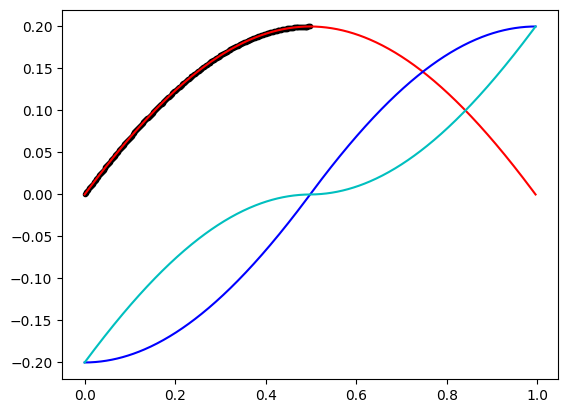

In [15]:
class curve_kernel(): # default is gaussian
  def __init__(self, angle = 30.0, horiz_d = 1.0, curve_h_of_c = 0.66, N=500, std=250):
    # angle is not used for gaussian
    self.angle = angle;
    self.horiz_d = horiz_d
    self.curve_h_of_c = curve_h_of_c
    self.a = [0,0]
    self.mid = [horiz_d/2,0]
    self.c = [horiz_d/2, tan(radians(angle))*horiz_d/2]
    len = int(floor(N/2))

    curve_x = np.arange(0, horiz_d,horiz_d/N)
    curve_y = signal.gaussian(N, std)
    curve_y -= min(curve_y)
    curve_y *= curve_h_of_c/max(curve_y)
    self.curve = np.array([curve_x[0:len], curve_y[0:len]])
    self.offset = self.curve[0,-1] #+ horiz_d/N

  def __repr__(self):
    plt.plot(self.curve[0,:], self.curve[1,:])
    print("Distance a to c: {:2.2}".format(distance.euclidean(self.a, self.c)))
    return ("Angle {}, d {}, A {}, B {}, C {}".format(self.angle, self.horiz_d,
                                                    self.a, self.mid, self.c))
class curves():
  def __init__(self, kernel):
    self.kernel = kernel.curve
    self.offset = kernel.curve[0,-1]
    self.h      = max(kernel.curve[1,:])
    self.len    = 2*len(kernel.curve[1,:])

    self.a_curve = self.concatenate(first = self.kernel,
                                    second = self.reverse(self.kernel))

    self.b_curve = self.concatenate(first = self.negative(self.reverse(self.kernel)),
                                    second = self.kernel)

    c = self.yoffset(self.kernel, -self.h)
    self.c_curve = self.concatenate(first = c,
                                    second = self.negative(self.reverse(c)))

  def yoffset(self, curve, offset):
    curve = np.copy(curve)
    curve[1,:] += offset
    return curve

  def negative(self, curve):
    curve = np.array([curve[0,:], -curve[1,:]])
    return curve

  def reverse(self, curve):
    curve = np.array([curve[0,:], np.flip(curve[1,:])])
    return curve

  def roll(self, curve, rollby):
    curve = np.copy(curve)
    nanarray = np.argwhere(np.isnan(curve))
    curve[1,:] = np.concatenate((curve[1,rollby:], curve[1,0:rollby]))
    for x,y in nanarray: # put back in discontinuities
      curve[x,y] = nan
    return curve

  def concatenate(self, first, second):
    if first is None:
      return second
    xoffset = first[0,-1]
    second = np.copy(second)
    second[0,:] += xoffset
    return(np.concatenate((first, second), axis=1))

  def __repr__(self):
    plt.plot(self.kernel[0,:], self.kernel[1,:], 'k.')
    plt.plot(self.a_curve[0,:], self.a_curve[1,:], 'r')
    plt.plot(self.b_curve[0,:], self.b_curve[1,:], 'b')
    plt.plot(self.c_curve[0,:], self.c_curve[1,:], 'c')
    return ""

ckernel = curve_kernel(60.0, curve_h_of_c=0.2, std=400)
cvs = curves(ckernel)
print(cvs)

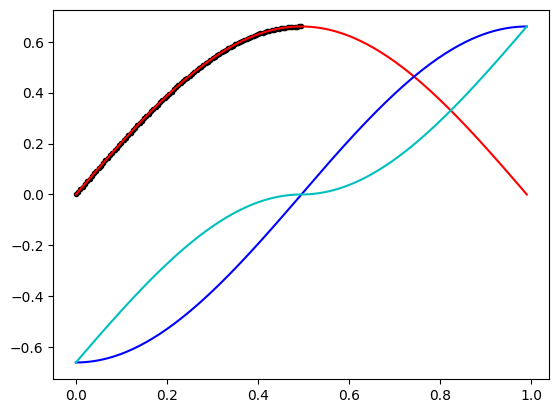

In [16]:
from mpmath import *
class algebraic_kernel(curve_kernel):  # Witch of Agnesi
  def __init__(self, angle = 20.0, horiz_d = 1.0, curve_h_of_c = 0.66, N=500, std=250):

    self.angle = np.radians(angle);
    self.horiz_d = horiz_d
    self.curve_h_of_c = curve_h_of_c
    self.a = [0,0]
    self.mid = [horiz_d/2,0]
    self.c = [horiz_d/2, tan(radians(self.angle))*horiz_d/2]

    len = int(floor(N/2))

    curve_x = np.arange(0, horiz_d,horiz_d/N)
    curve_x_mod = curve_x*10
    a = self.angle
    curve_y = 8*a**3 / (curve_x_mod*curve_x_mod + 4*a**2)
    curve_y = curve_y[0:len]
    curve_y -= curve_y.min()
    curve_y /= curve_y.max()
    curve_y *= curve_h_of_c

    self.curve = np.array([curve_x[0:len], np.flip(curve_y[0:len])])
    self.offset = self.curve[0,-1] #+ horiz_d/N

  def __repr__(self):
    plt.plot(self.curve[0,:], self.curve[1,:])
    print("Distance a to c: {:2.2}".format(distance.euclidean(self.a, self.c)))
    return ("Angle {}, d {}, A {}, B {}, C {}".format(self.angle, self.horiz_d,
                                                    self.a, self.mid, self.c))

test = algebraic_kernel(angle= 270, N=200, curve_h_of_c=0.66)
cvs = curves(test)
print(cvs)



<ipython-input-17-796a9ac30373>:16: RuntimeWarning: divide by zero encountered in divide
  curve_y = np.exp(-1.0/(1.0-curve_xsq))


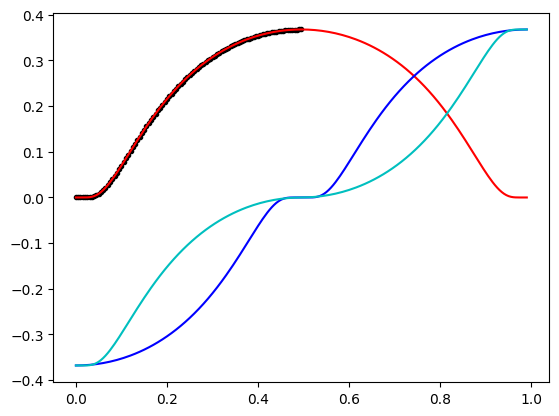

In [17]:
class bump_kernel(curve_kernel):
  def __init__(self, angle = 30.0, horiz_d = 1.0, curve_h_of_c = 0.66, N=500, std=250):
    if (angle < 20.0) or (angle > 70.0):
      print("WARNING: CAB angle {} should be between 20 and 70 degrees".format(angle))

    self.angle = angle;
    self.horiz_d = horiz_d
    self.curve_h_of_c = curve_h_of_c
    self.a = [0,0]
    self.mid = [horiz_d/2,0]
    self.c = [horiz_d/2, tan(radians(angle))*horiz_d/2]
    len = int(floor(N/2))

    curve_x = np.arange(0, horiz_d,horiz_d/N)
    curve_xsq = 4*curve_x*curve_x
    curve_y = np.exp(-1.0/(1.0-curve_xsq))

    self.curve = np.array([curve_x[0:len], np.flip(curve_y[0:len])])
    self.offset = self.curve[0,-1] #+ horiz_d/N

  def __repr__(self):
    plt.plot(self.curve[0,:], self.curve[1,:])
    print("Distance a to c: {:2.2}".format(distance.euclidean(self.a, self.c)))
    return ("Angle {}, d {}, A {}, B {}, C {}".format(self.angle, self.horiz_d,
                                                    self.a, self.mid, self.c))

bk = bump_kernel(N=200, curve_h_of_c=1.0)
cvs_bk = curves(bk)
print(cvs_bk)


I want to be able to use the Amanda Ghassaei's [Origami Simulator](https://origamisimulator.org/) to test the output of the script.

In this next block, I'm fixing up the matplotlib output to be more compatible with the simulator.

In [18]:
indef = False
def rm_clippath(line):
  global indef

  if not indef:
    f = line.find('<clipPath')
  else:
    f = line.find('</clipPath>')
  if f >= 0:
    indef = not indef
    return ""
  if indef: return ""

  f = line.find('clip-path')
  if (f < 0): return line
  fc = line.find('"', f) + 1
  fe = line.find('"', fc) +1
  return line[:f]+line[fe:]

def fixup_svg(infile):
  global indef
  indef = False
  outfile = "kt_"+ infile
  replace_list = [['fill:none;',""], ['style="fill:#ffffff;"/>','style="fill:none;stroke:#000000"/>' ]]
  with open(infile) as fin, open(outfile, "w+") as fout:
    for line in fin:
      line = rm_clippath(line)
      for pair in replace_list:
        line = line.replace(pair[0], pair[1])
      fout.write(line)
  return outfile


Create a small language to interpret how to put together the curves to create a pattern.

In [19]:
def curveNoneZero(curve, dcat):
  if curve is None:
    curve = np.zeros((2,1))
    curve[1] = dcat[1][0]
  return curve

def A_curve(curve, cvs, mult):
  cat = mult*np.copy(cvs.a_curve)
  curve = curveNoneZero(curve, cat)
  return cvs.concatenate(curve, cat)
def a_curve(curve, cvs, mult):
  cat = mult*cvs.yoffset(cvs.a_curve, -cvs.h)
  curve = curveNoneZero(curve, cat)
  return cvs.concatenate(curve, cat)
def B_curve(curve, cvs, mult):
  cat = mult*np.copy(cvs.b_curve)
  curve = curveNoneZero(curve, cat)
  return cvs.concatenate(curve, cat)
def b_curve(curve, cvs, mult):
  cat = mult*cvs.reverse(cvs.b_curve)
  curve = curveNoneZero(curve, cat)
  return cvs.concatenate(curve, cat)
def C_curve(curve, cvs, mult):
  cat = mult*np.copy(cvs.c_curve)
  curve = curveNoneZero(curve, cat)
  return cvs.concatenate(curve, cat)
def c_curve(curve, cvs, mult):
  cat = mult*cvs.reverse(cvs.c_curve)
  curve = curveNoneZero(curve, cat)
  return cvs.concatenate(curve, cat)
def U_curve(curve, cvs, mult):
  cat = mult*cvs.negative(np.copy(cvs.a_curve))
  curve = curveNoneZero(curve, cat)
  return cvs.concatenate(curve, cat)
def u_curve(curve, cvs, mult):
  cat = mult*cvs.negative(cvs.yoffset(cvs.a_curve, -cvs.h))
  curve = curveNoneZero(curve, cat)
  return cvs.concatenate(curve, cat)

def horizline_curve(curve, cvs, mult):
  xoffset = (cvs.a_curve[0,-1])
  line = np.array([[0,xoffset],[0,0]])
  return cvs.concatenate(curve, mult*line)

def pipe_curve(curve, cvs, mult):
  pipe = np.array([[0,0],[0,cvs.h]])
  return cvs.concatenate(curve, mult*pipe)

def blank_curve(curve, cvs, mult):
  xoffset = (cvs.a_curve[0,-1])*mult
  blank = np.array([[0, xoffset],[np.nan,np.nan]])
  return cvs.concatenate(curve, blank)

def parse_multi_multiplier_array(mult):
  xmult = 1.0
  ymult = 1.0
  if type(mult) is list:
    if (len(mult) == 2):
      xmult, ymult = mult[0], mult[1]
  else: # not a list
    xmult = mult
  return xmult, ymult

def forward_slash(curve, cvs, mult):
  xmult,ymult = parse_multi_multiplier_array(mult)
  slash = np.arange(0, cvs.len-1)/(cvs.len-1)
  line = np.array([slash, ymult*(slash)])
  return cvs.concatenate(curve, xmult*line)

def backward_slash(curve, cvs, mult):
  xmult,ymult = parse_multi_multiplier_array(mult)
  slash = np.arange(0, cvs.len-1)/(cvs.len-1)
  line = np.array([slash, ymult*(np.flip(slash))])
  return cvs.concatenate(curve, xmult*line)

def paper_break(curve, cvs, mult):
  pipe = np.array([[0,0],[0,cvs.h/20]])
  return cvs.concatenate(curve, mult*pipe)

# New and poorly tested!
def rotate_curve(curve, cvs, degrees, origin=(0,0)):
    angle = np.deg2rad(degrees)
    R = np.array([[np.cos(angle), -np.sin(angle)],
                  [np.sin(angle),  np.cos(angle)]])
    o = np.atleast_2d(origin).T
    npcurve = np.atleast_2d(curve)
    npcurve = (R @ (npcurve-o) + o)
    return npcurve


def rollctl(cvs,e):
  mult = 1.0
  if len(e) > 1:
    mult= float(e[1:])
  return int(floor(mult*cvs.len/2))

def heightctl(cvs, e):
      return (float(e[1:]) * cvs.h)

def heightctl_unmoderated(cvs, e):
      return (float(e[1:]))

def color_red():
  return 'r-'
def color_blue():
  return 'b-'
def color_black():
  return 'k-'
def color_green():
  return 'g-'


# This is the pattern creator interpretor
# each one of these can be followed by a multiplier that indicates
# how wide or tall it should be
interpret_curve = {
    "A"   : A_curve,             # Downward facing U-shaped curve, starts at Y midpoint
    "a"   : a_curve,             # Downward facing curve, starts at min Y
    "B"   : B_curve,             # Forward B (S shaped cuve)
    "b"   : b_curve,             # Backward B, use with B will create a sinusoid
    "C"   : C_curve,             # Forward C (often inverse S, depends on kernel)
    "c"   : c_curve,             # Backward C, use with C will not create sinusoid
    "U"   : U_curve,              # Upward facing U-shaped curve, starts at Y midpoint
    "u"   : u_curve,              # Upward facings, starts at min Y
    "-"   : horizline_curve,      # One curve's worth of horizontal line
    "|"   : pipe_curve,           # A vertical line (no horizontal)
    "x"   : blank_curve,          # Blank space, one curve's worth
    "f"   : forward_slash,        # The multiplier controls height and width
    "s"   : backward_slash,       # The multiplier controls height and width
    "*"   : paper_break,          # Same as | but with a an x to break the paper
    "r"   : rotate_curve,         # rotate curve from its current position: # New and poorly tested!
}

roll_control = {
    "o"   : rollctl                 # move some points from the left to the right
}
height_control = {
    "h"   : heightctl,              # height of the curve
    "H"   : heightctl_unmoderated   # height of the line area
}

colors = {
    "red" : color_red,
    "blue": color_blue,
    "blk" : color_black,
    "green" : color_green
}

def interpret_line(yoffset, line, cvs, add_plot=True):
  elements = line.split()
  curve = None
  color = 'k'
  rollby = 0
  height = cvs.h
  for e in elements:
    if e[0] in roll_control:
      rollby = roll_control[e[0]](cvs, e)
    elif e in colors:
      color = colors[e]()
    elif e[0] in height_control:
      height = height_control[e[0]](cvs, e)
    elif e[0] in interpret_curve:
      mult = 1.0
      if len(e) > 1:
        split = e[1:].split(",",1)
        if len(split) == 1:
          mult = float(split[0])
        else:
          mult = [float(x) for x in split]
      curve = interpret_curve[e[0]](curve, cvs, mult)
  curve = cvs.roll(curve, rollby)
  curve = cvs.yoffset(curve, yoffset)
  if add_plot:
    plt.plot(curve[0,:], curve[1,:], color)
  return color, curve, height

def minmax(minxy, maxxy, curve):
  new_minxy = np.nanmin(curve, 1)
  new_maxxy = np.nanmax(curve, 1)
  minxy = np.nanmin(np.stack((minxy, new_minxy), 1),1)
  maxxy = np.nanmax(np.stack((maxxy, new_maxxy), 1),1)
  return minxy, maxxy

def plot_outer_box(minxy, maxxy, color='k'):
  plt.plot([minxy[0], minxy[0]], [minxy[1],maxxy[1]], color )
  plt.plot([maxxy[0], maxxy[0]], [minxy[1],maxxy[1]], color )
  plt.plot([minxy[0], maxxy[0]], [minxy[1],minxy[1]], color )
  plt.plot([minxy[0], maxxy[0]], [maxxy[1],maxxy[1]], color )

def interpret_tess(name, input, cvs, outputfile=True, ax=None):
  minxy = np.ones((2)) * nan
  maxxy = np.ones((2)) * nan
  yoffset = 0.0
  for line in input:
    color, curve, height = interpret_line(yoffset, line, cvs)
    minxy, maxxy = minmax(minxy, maxxy, curve)
    yoffset -= height
  if ax is not None:
    plt.axis(ax)
  else:
    plt.axis('equal')
  plt.axis('off')

  plot_outer_box(minxy, maxxy, 'k')
  plt.savefig(name + ".svg")
  outputfilename = fixup_svg(name + ".svg")
  if outputfile:
    files.download(outputfilename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

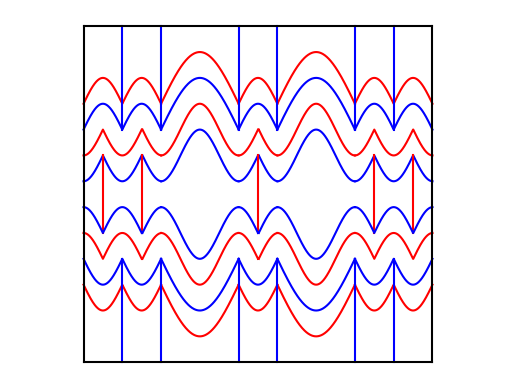

In [20]:
name = "pretty22" # Similar to Lukasheva's p22 in the Curved Origami patterns PDF
pretty22 = [
          "red a a x x a x x a a h1",
          "red  x x A2  x A2 h0",
          "blue a a x x a x x a a h1",
          "blue x |4 x |4 x x |4 x |4 x x |4 x |4 h0",
          "blue  x x A2  x A2 h0",

          "red  x x B b x B b x h1",
          "red  o u u x x u x x u u h0",

          "blue  x x B b x B b x h1",
          "blue  o u u x x u x x u u h2",

          "red   x0.5 |3 x |3 x3 |3 x3 |3 x |3 h-1",

          "blue  o a a x x a x x a a h1",
          "blue  x x b B x b B x h0",

          "red  o a a x x a x x a a h1",
          "red  x x b B x b B x h0",

          "blue  x x U2  x U2 h1",
          "blue u u x x u x x u u h0",

          "red   x x U2  x U2 h1",
          "red  u u x x u x x u u h2",
          "blue x |4 x |4 x x |4 x |4 x x |4 x |4 h0",

]
interpret_tess(name, pretty22, cvs)